In [2]:
import sys
sys.path.append('./external')

from engine import train_one_epoch, evaluate
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

import cv2
import numpy as np
import os
import torch
import torchvision
import transforms as T
import utils

In [3]:
TRAIN_MODEL = False
TRAIN_EPOCHS = 10
TEST_MODEL = True
TEST_IMAGES_TO_VISUALIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2
MODEL_PATH = './model.pth'

In [4]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
def fasterrcnn_resnet50_fpn(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2  # 1 class (person) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    
    return model
    
    
def fasterrcnn_mobilenet2(num_classes):
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280

    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                    output_size=7,
                                                    sampling_ratio=2)

    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

    return model

In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

if TRAIN_MODEL:
    # get the model using our helper function
    model = fasterrcnn_mobilenet2(NUM_CLASSES)

    # move model to the right device
    model.to(DEVICE)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for TRAIN_EPOCHS epochs
    for epoch in range(TRAIN_EPOCHS):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
        
    torch.save(model.state_dict(), MODEL_PATH)
    
    print("That's it!")

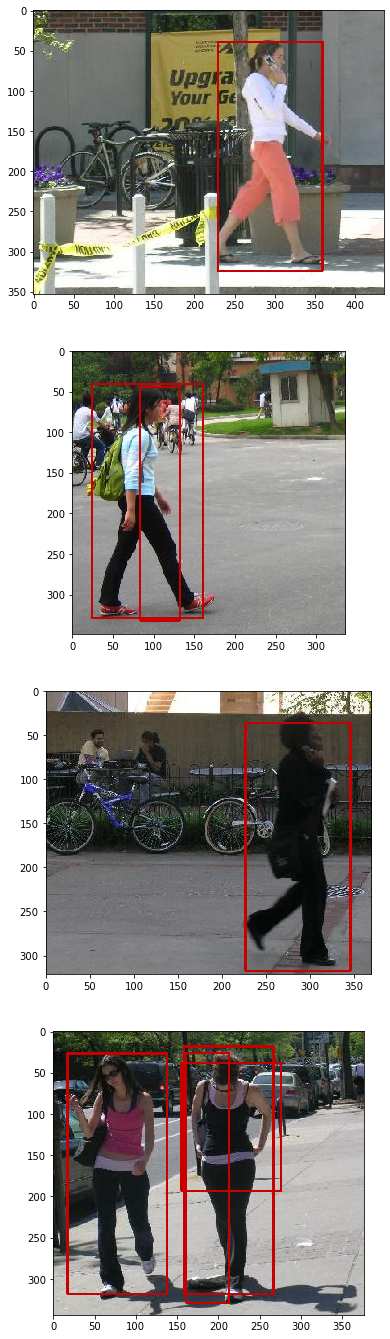

In [11]:
if TEST_MODEL:
    model = fasterrcnn_mobilenet2(NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()

    f, axarr = plt.subplots(TEST_IMAGES_TO_VISUALIZE, 1, figsize=(32, 24))

    for i, (image, target) in enumerate(data_loader_test):
        image = list(img.to(0) for img in image)
        outputs = model(image)
    
        bboxes = outputs[0]['boxes'].cpu().data.numpy()
        scores = outputs[0]['scores'].cpu().data.numpy()
        mask = scores > 0.5
    
        bboxes = bboxes[mask]
        scores = scores[mask]
    
        vis = image[0].cpu().data.numpy() * 255
        vis = vis.transpose(1, 2, 0).astype(np.uint8)
    
        for b in bboxes:
            x0, y0, x1, y1 = [int(x) for x in b]
            vis = cv2.rectangle(vis, (x0, y0), (x1, y1), (200, 0, 0), 2)

        axarr[i].imshow(vis.get())
        if i == TEST_IMAGES_TO_VISUALIZE - 1:
            break 